# Introduction to GLayout

Notes and adaptation of the examples given on the original presentation.
Link to original [Notebook](https://colab.research.google.com/drive/1mU7-zmAWgDRJqaZGP-RkSXCSgRkHOb--?usp=sharing) and [presentation](https://docs.google.com/presentation/d/e/2PACX-1vTk7bVKei6T-s2QTc1YKjJITN88SnlizilX3w7ku_OZQMn1Mu00oJd25nxcwHBJ-A/pub?start=false&loop=false&delayms=3000&slide=id.p1).

## Introducing GLayout

- Programmatic generation of cells. Each cell can have parameters.
- Decouple the procedure from the specifics of the pdk by using **Generic Layers**.
- Hierarchical design.
- There are macros for place and route.

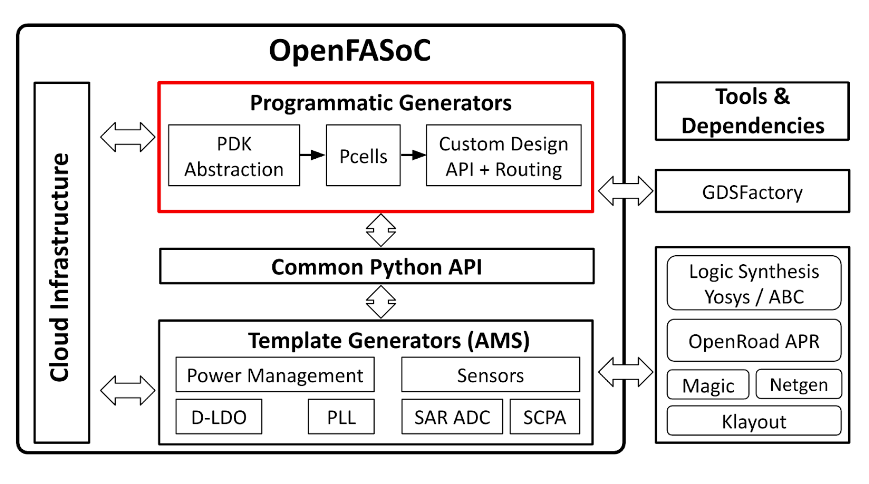



MappedPDK:

- PDK Abstraction, avoid pdk specifics for common things.

- Python dictionaries with rules and layers
- Generic Layers: Process independent names
- Generic Rules

GLayers:

- `pdk.get_glayer()` returns the association between the glayer and process-specific one.
- Used to generate rectangles.

FEOL: Poly, n-select.

BEOL: Metal1, Via1, Metal2, Via2

GRules: `27:18`

- Used to specify dimentions and spacing
- `pdk.get_grule()`: String for layer, type of rule... (?)


Vias has size and metal enclosure requirements, different from process to process.

Ports: `30:10`

- The edge of a polygon.
- Center, width and orientation (Something like the "normal" vector)
- Port Hierarchy: Allows to access pins of a device

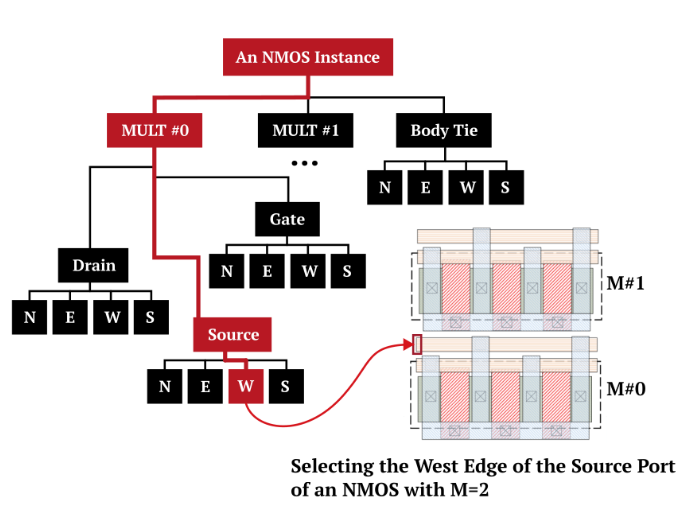

Routing:

- Set of macros to route:
    - C Route
    - Straight route
    - L route

## Questions

### Purpose and Scope questions

> Some layers are process-specific. Is possible to standarize the way in which the processes diverge? Like different flavors with the same core?
> - Sky130 uses TAP and DIFF, while GF180 uses COMP

> Restricting the question to CMOS tecnologies. PDK Rules also dictates the use of different structures that might have different caracteristics between processes.
> How GLayout allows a design to support this differences?
>
> Examples:
>
> - Guard rings structure and when should be use them
> - mimcap connections only on top-metal

> Is there a way to reuse pdk specific pcells?

> Can we validate that the output of a cell is consistent? Not only DRC

### Technical questions

> What if the routing logic becomes more complex than the proposed macros?

> How to configure the via size according to the current it is going to move

> In GLayout, defining a port change the hierarchy, but affects the layout? In the same way, does defining a route change the hierarchy? Can we validate that both are satisfied?

> Is there a way to run some testing framework to validate the pcells are working as expected on different pdks?

## Notes

> Estoy en minuto 34 del video, empezó a revisar el notebook

Notas de la presentación..

Podemos hacer un Fork de algo... que cosa? Supongo que a GLayout

Estamos transitando a fase 2.
Team up, fundamentos de diseño, prácticas de diseño.
Contribuciones por medio de pull request, hay guidelines igual

Component Demos

### Transistor Primitive

- Parametrizado en Glayout
- Soporta M y NF
- Soporta inserción de DUMMY.
- Enclosing Rings

La parte de los dummies parece extraña.

OpenFASOC/openfasoc/generators/glayout/glayout/flow/primitives/fet.py

## Tap Ring

Protegen componentes sensibles.

## Interdigitated Placement

- Macros.
- Procesos tienen un gradiente en variacion de procesos
- se utiliza al hacer matching.
- Configuración horizontal para hacer que transistores hagan match.
- Son varias macros

[Placement](https://github.com/idea-fasoc/OpenFASOC/tree/main/openfasoc/generators/glayout/glayout/flow/placement)

## Common Centroid Placement

- También existe
- Soporta definir otros patrones?

## Routing

- Solo hay soporte de 3 tipos.
- Widths del track. 

> Como hacerlo tecnology agnostic?

## Current Mirror

Se harán 3 configuraciones distintos

- 2 transistores
- Interdigitated
- Common Centroid

Acá se pone a revisar un notebook

In [25]:
# Primitives
from glayout.flow.primitives.fet import pmos
from glayout.flow.primitives.guardring import tapring

# Standard
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.pdk.gf180_mapped import gf180_mapped_pdk as gf180
from gdsfactory import Component

# Utilities
from glayout.flow.pdk.util.comp_utils import evaluate_bbox, prec_center

# Routing
from glayout.flow.routing.straight_route import straight_route
from glayout.flow.routing.c_route import c_route


def currentMirror(pdk: MappedPDK):
    # Create top level component
    current_mirror = Component()

    pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(True, False))
    pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(False, True))
    pfet_ref_ref = current_mirror << pfet_ref
    pfet_mir_ref = current_mirror << pfet_mir

    # Placement: Relative move
    ref_dimensions = evaluate_bbox(pfet_ref_ref)
    pfet_mir_ref.movex(ref_dimensions[0] + pdk.util_max_metal_seperation())

    # Routing: Straight line for source and gates, c_route for reference drain and gate.
    current_mirror << straight_route(
        pdk,
        pfet_ref_ref.ports["multiplier_0_source_E"],
        pfet_mir_ref.ports["multiplier_0_source_W"],
    )

    current_mirror << straight_route(
        pdk,
        pfet_ref_ref.ports["multiplier_0_gate_E"],
        pfet_mir_ref.ports["multiplier_0_gate_W"],
    )

    current_mirror << c_route(
        pdk,
        pfet_ref_ref.ports["multiplier_0_drain_W"],
        pfet_ref_ref.ports["multiplier_0_gate_W"],
    )

    # Adding a Tap Ring
    shift_amount = prec_center(current_mirror.flatten())[0]
    tap_ring = current_mirror << tapring(
        pdk,
        enclosed_rectangle=evaluate_bbox(
            current_mirror.flatten(), padding=pdk.util_max_metal_seperation()
        ),
    )
    tap_ring.movex(-shift_amount)

    return current_mirror


currentMirror(gf180).show()

/usr/local/lib/python3.10/dist-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 4 in 'Unnamed_b1474e41'
  gdspath = component.write_gds(
2024-06-27 18:09:39.241 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.3.2", "type": "open", "file": "/tmp/gdsfactory/Unnamed_b1474e41.gds"}
